In [ ]:
! pip install plotly>=4.7.1
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [2]:
import pandas as pd
import numpy as np
import json
import nltk
import gensim
nltk.download('stopwords')
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 
stop_words2 = set([word.strip() for word in open('stopwords.txt')])
import plotly.express as px

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Part 1: Import data

Load in data from scp file transfers in the form of pandas dataframes

In [3]:
posts = pd.read_csv('posts.csv')
posts.head(3)

,body,score
0,Just wanted to update with my personal experie...,23
1,"I’m currently on Emgality monthly, with topira...",24
2,Anyone have experience with a CGRP that was wo...,16


In [4]:
replies = pd.read_csv('replies.csv')
replies.head(3)

,replies,score
0,"[{""comment_1"":""That’s great. I hope it continu...",23
1,"[{""comment_1"":""As a nurse, Im sure this is inf...",24
2,"[{""comment_1"":""Yes. This is what happened to m...",16


### Part 2: Cleanse data
Convert 'replies' dataframe into a more useable format. Cleanse both datasets of special characters, whitespaces, and convert to lowercase.

In [5]:
# function to cleanse data
def cleanse_text(df,col):
  """
  Remove stopwords
  Remove special characters
  """
  spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–","\xa0","\xa0å","”","“"]

  for char in spec_chars:
      df[col] = df[col].str.replace(char, ' ').str.replace('  ',' ').str.lower().str.strip()

  doc = []

  for sentence in df[col]:
    sentence = sentence.split(" ")
    for word in sentence:
      if word not in stop_words:
        if word not in stop_words2:
          doc.append(word.strip())

  return doc

In [6]:
replies_cleansed = pd.DataFrame(columns=['Comments'])

comment_list = []
for reply in replies.replies:
  comments = json.loads(reply)
  for comment in comments:
    comment_list.append(" ".join(list(comment.values())))

replies_cleansed['Comments'] = comment_list
replies_cleansed.head(3)

,Comments
0,That’s great. I hope it continues to work so w...
1,"As a nurse, Im sure this is info youre well aw..."
2,Yes. This is what happened to me. Each of the ...


### Part 3: Perform NLTK on Unigrams
This will be used to analyze and visualize most frequent words from 1000 cgrpMigraine subreddit posts and comments.

In [7]:
# feed dataframes through text cleansing functions
post_doc = cleanse_text(posts,'body')
replies_doc = cleanse_text(replies_cleansed,'Comments')

# convert in dictionary form
docs = [post_doc,replies_doc]
dictionary = gensim.corpora.Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]

# compute frequencies
tfidf = gensim.models.TfidfModel(corpus)
post_bow = pd.Series({dictionary[id]:np.around(freq, decimals=2) for id, freq in tfidf[corpus[0]]}).to_frame()
replies_bow = pd.Series({dictionary[id]:np.around(freq, decimals=2) for id, freq in tfidf[corpus[1]]}).to_frame()

post_bow.columns = ['Frequency']
replies_bow.columns = ['Frequency']

In [8]:
# store top 50 most frequent words from comments
post_top_50 = post_bow.sort_values(by='Frequency',ascending=False).iloc[0:51,:]
post_top_50.head(3)

,Frequency
lupus,0.22
etc,0.19
https,0.19


In [9]:
# store top 50 most frequent words from replies
replies_top_50 = replies_bow.sort_values(by='Frequency',ascending=False).iloc[0:51,:]
replies_top_50.head(3)

,Frequency
belly,0.27
thigh,0.23
thank,0.23


### Part 4: Perform NLTK functions on bigrams
This will be used to analyze and visualize bigrams (pair of two words) from 1000 cgrpMigraine subreddit posts and comments.

In [10]:
# compute bigrams on tokens
post_bigrams = list(nltk.bigrams(cleanse_text(posts,'body')))
replies_bigrams = list(nltk.bigrams(cleanse_text(replies_cleansed,'Comments')))

In [11]:
list(post_bigrams)[0:5]

[('wanted', 'update'),
 ('update', 'personal'),
 ('personal', 'experience'),
 ('experience', 'far'),
 ('far', 'i’d')]

In [12]:
list(replies_bigrams)[0:5]

[('that’s', 'great'),
 ('great', 'hope'),
 ('hope', 'continues'),
 ('continues', 'work'),
 ('work', 'well')]

In [13]:
# for every word, compute frequency distribution of bigrams
post_freq_dist = nltk.ConditionalFreqDist(post_bigrams)
replies_freq_dist = nltk.ConditionalFreqDist(replies_bigrams)

# Part 5: Visualize Most Frequent Unigrams
Visualize unigram word frequencies from posts and replies using plotly library.

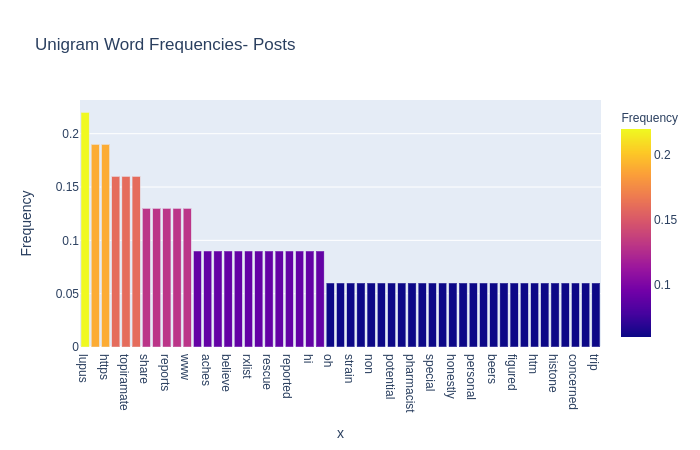

In [24]:
fig = px.bar(post_top_50, x=post_top_50.index, y="Frequency",color="Frequency",title="Unigram Word Frequencies- Posts")
fig.show("png")

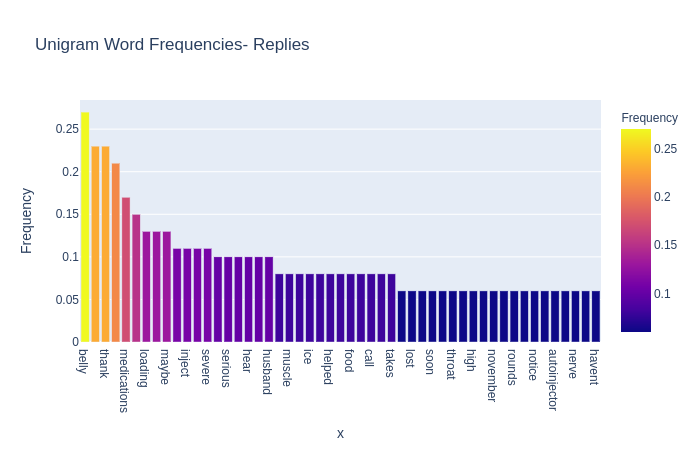

In [25]:
fig = px.bar(replies_top_50, x=replies_top_50.index, y="Frequency",color="Frequency",title="Unigram Word Frequencies- Replies")
fig.show("png")

### Part 6- Visualize Bigram Frequencies
The bigram frequency distribution stores all the word associations in the form of a nested dictionary. I will visualize some interesting key words to see what other words they are associated with.

There are three cgrp autoinjector medications: Aimovig, Emgality, and Ajovy. For every drug (word), I will visualize bigrams for each word, for both posts and replies.

#### Aimovig Post and Replies Bigrams

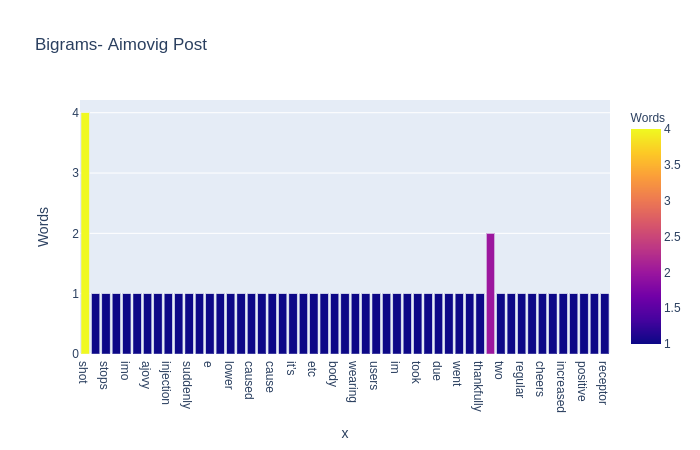

In [18]:
# convert selected bigrams into dataframes
aimovig_post = pd.Series(dict(post_freq_dist['aimovig'])).to_frame()
aimovig_post.columns = ['Words']
fig = px.bar(aimovig_post, x=aimovig_post.index, y='Words',color='Words',title="Bigrams- Aimovig Post")
fig.show("png")

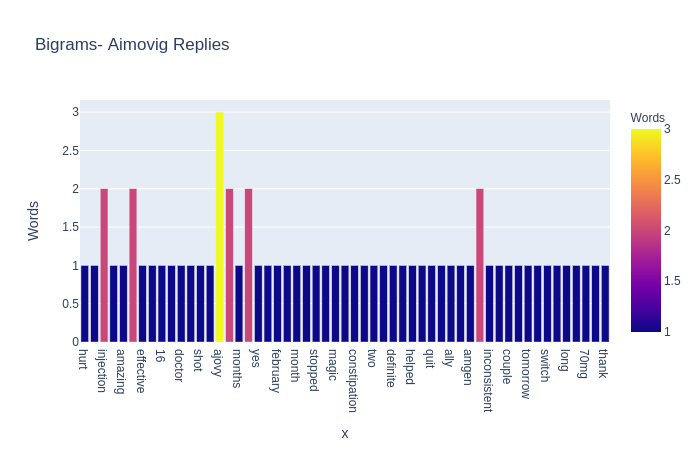

In [26]:
# convert selected bigrams into dataframes
aimovig_replies = pd.Series(dict(replies_freq_dist['aimovig'])).to_frame()
aimovig_replies.columns = ['Words']
fig = px.bar(aimovig_replies, x=aimovig_replies.index, y='Words',color='Words',title="Bigrams- Aimovig Replies")
fig.show("png")

#### Emgality Post and Replies Bigrams

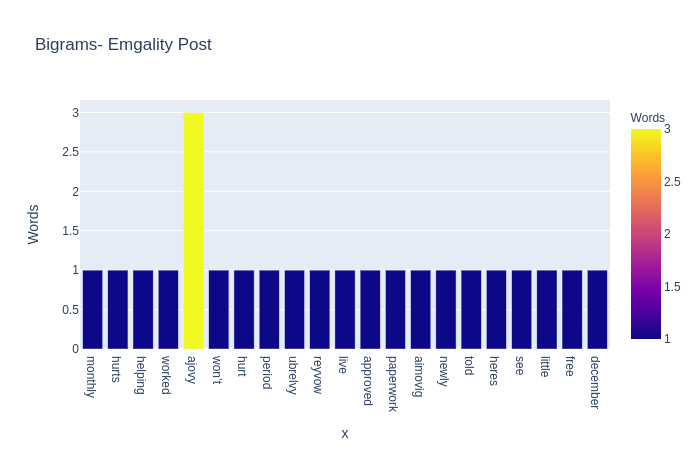

In [27]:
# convert selected bigrams into dataframes
emgality_post = pd.Series(dict(post_freq_dist['emgality'])).to_frame()
emgality_post.columns = ['Words']
fig = px.bar(emgality_post, x=emgality_post.index, y='Words',color='Words',title="Bigrams- Emgality Post")
fig.show("png")

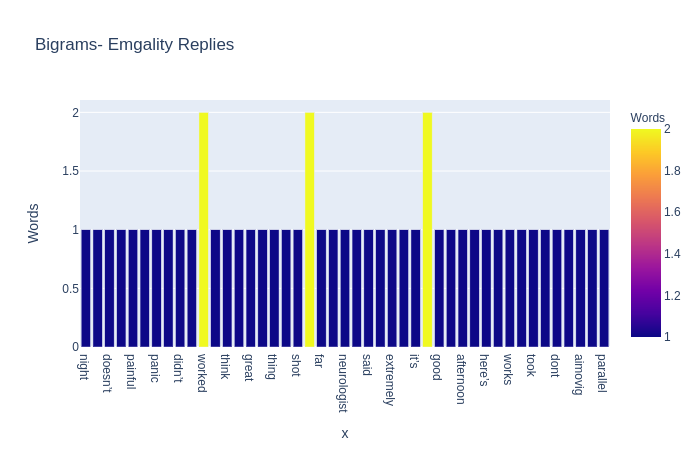

In [28]:
# convert selected bigrams into dataframes
emgality_replies = pd.Series(dict(replies_freq_dist['emgality'])).to_frame()
emgality_replies.columns = ['Words']
fig = px.bar(emgality_replies, x=emgality_replies.index, y='Words',color='Words',title="Bigrams- Emgality Replies")
fig.show("png")

#### Ajovy Post and Replies Bigrams

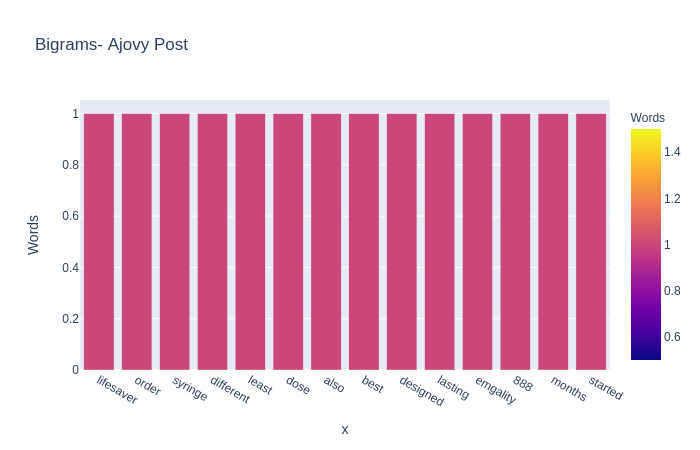

In [29]:
# convert selected bigrams into dataframes
ajovy_post = pd.Series(dict(post_freq_dist['ajovy'])).to_frame()
ajovy_post.columns = ['Words']
fig = px.bar(ajovy_post, x=ajovy_post.index, y='Words',color='Words',title="Bigrams- Ajovy Post")
fig.show("png")

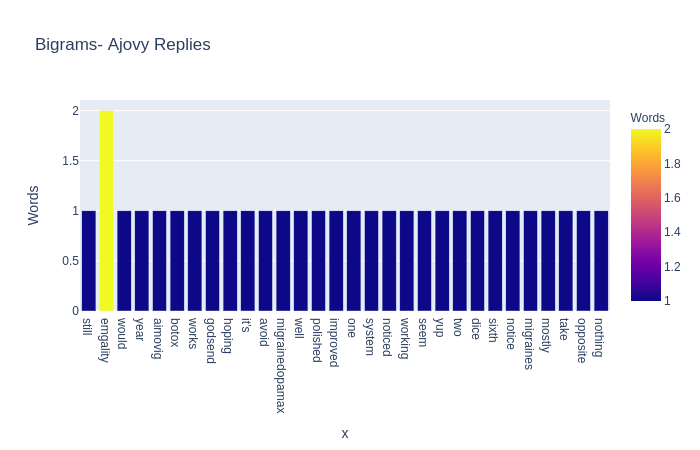

In [30]:
# convert selected bigrams into dataframes
ajovy_replies = pd.Series(dict(replies_freq_dist['ajovy'])).to_frame()
ajovy_replies.columns = ['Words']
fig = px.bar(ajovy_replies, x=ajovy_replies.index, y='Words',color='Words',title="Bigrams- Ajovy Replies")
fig.show("png")

### Part 7: Brief Analysis of Results
The visualizations of the unigrams and bigrams indicate topics of interest on this subreddit. From the unigram analysis, we can see that words of interest include words involving symptoms and how to perform injections.

The replies show that the three medications are referenced with one another. Many migraineurs have tried many of these medications, and they share their experience with each one with respect to Aimovig. So there's a lot of comparison across the drugs.

Replies seem to offer more anecdotal text compared to the posts. From personal experience using this subreddit, you can receive many replies to confirm your own experience with the drug. As a result, replies will have more words and more variety compared to a given post.